In [3]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import anndata as ad
import pandas as pd

In [4]:
sc.set_figure_params(figsize=(5, 5))

In [12]:
adata1 = sc.read_h5ad('../../results/01_cell_2022/scrna.skin.annotated.h5ad')
adata2 = sc.read_h5ad('../../results/02_nc_2021_Tabib/scrna.integrated.annotated.v2.h5ad')

In [15]:
adata1

AnnData object with n_obs × n_vars = 58351 × 45475
    obs: 'Well_ID', 'well_coordinates', 'Amp_batch_ID', 'Cell_barcode', 'Seq_batch_ID', 'Pool_barcode', 'Pool_barcode_i5', 'Number_of_cells', 'annotation', 'sample_name', 'selection_marker', 'source_name', 'tissue', 'patient_id', 'organism', 'batch', 'condition', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotation_colors', 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'selection_marker_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [16]:
adata1.obs = adata1.obs[['patient_id', 'condition', 'cell_type']]
adata1.obs['condition'] = adata1.obs['condition'].str.replace(r'Control', 'Healthy', regex=True)
adata1.obs['condition'] = adata1.obs['condition'].str.replace(r'SSC', 'SSc', regex=True)

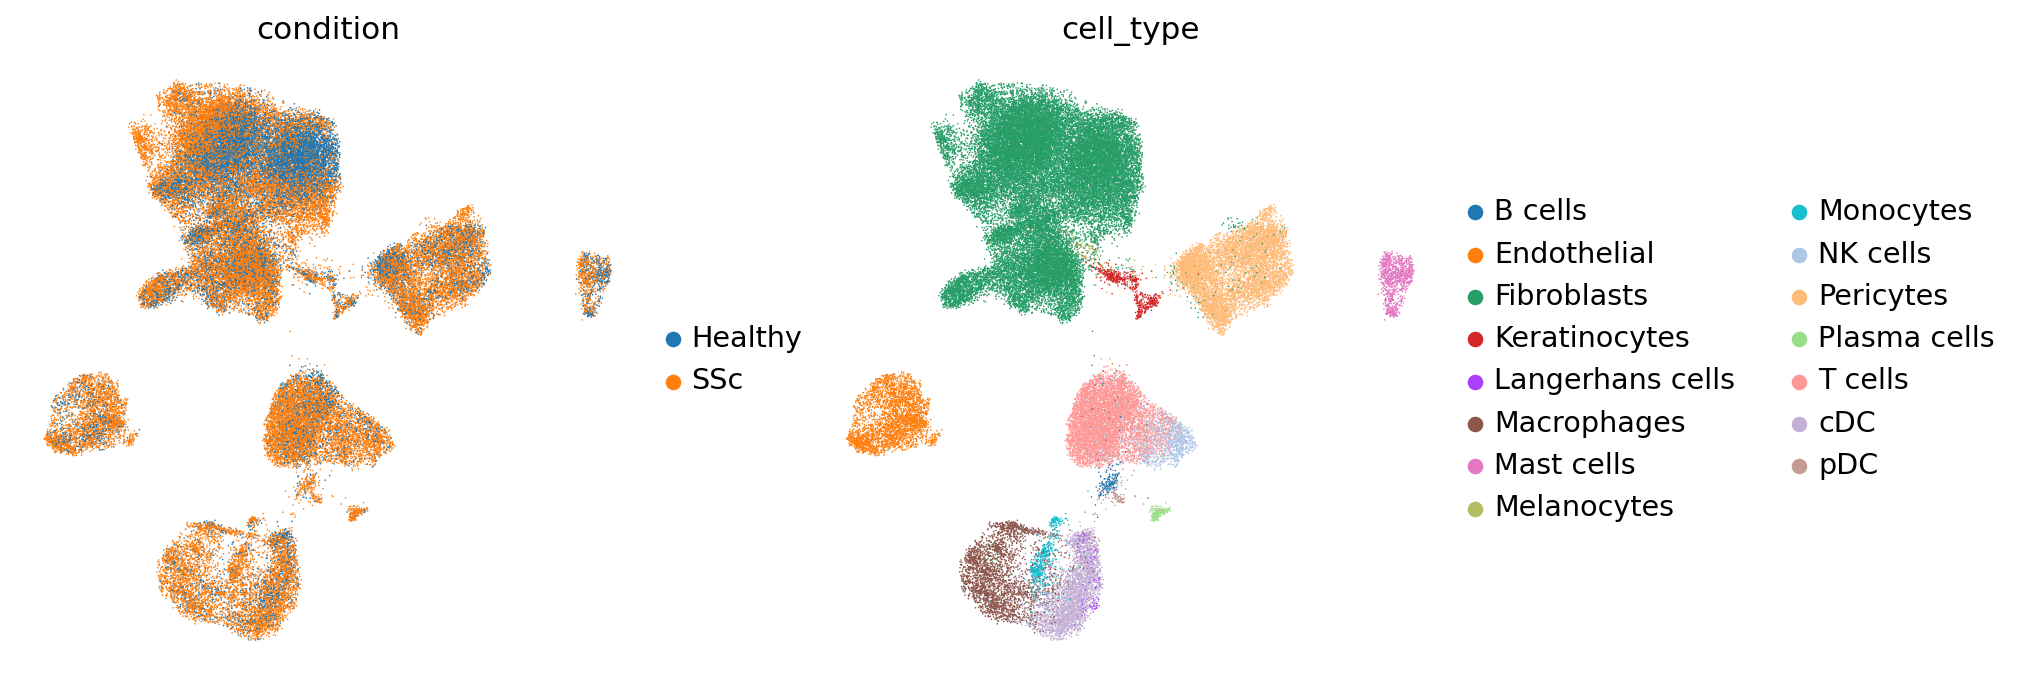

In [17]:
sc.pl.umap(adata1, color=['condition', 'cell_type'], frameon=False)

In [18]:
adata2

AnnData object with n_obs × n_vars = 37547 × 15540
    obs: 'n_genes', 'sample', 'condition', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [19]:
adata2.obs = adata2.obs[['sample', 'condition', 'cell_type']]

adata2.obs.rename(columns={"sample": "patient_id"}, inplace=True)
adata2.obs['condition'] = adata2.obs['condition'].str.replace(r'CONTROL', 'Healthy', regex=True)
adata2.obs['condition'] = adata2.obs['condition'].str.replace(r'SSC', 'SSc', regex=True)

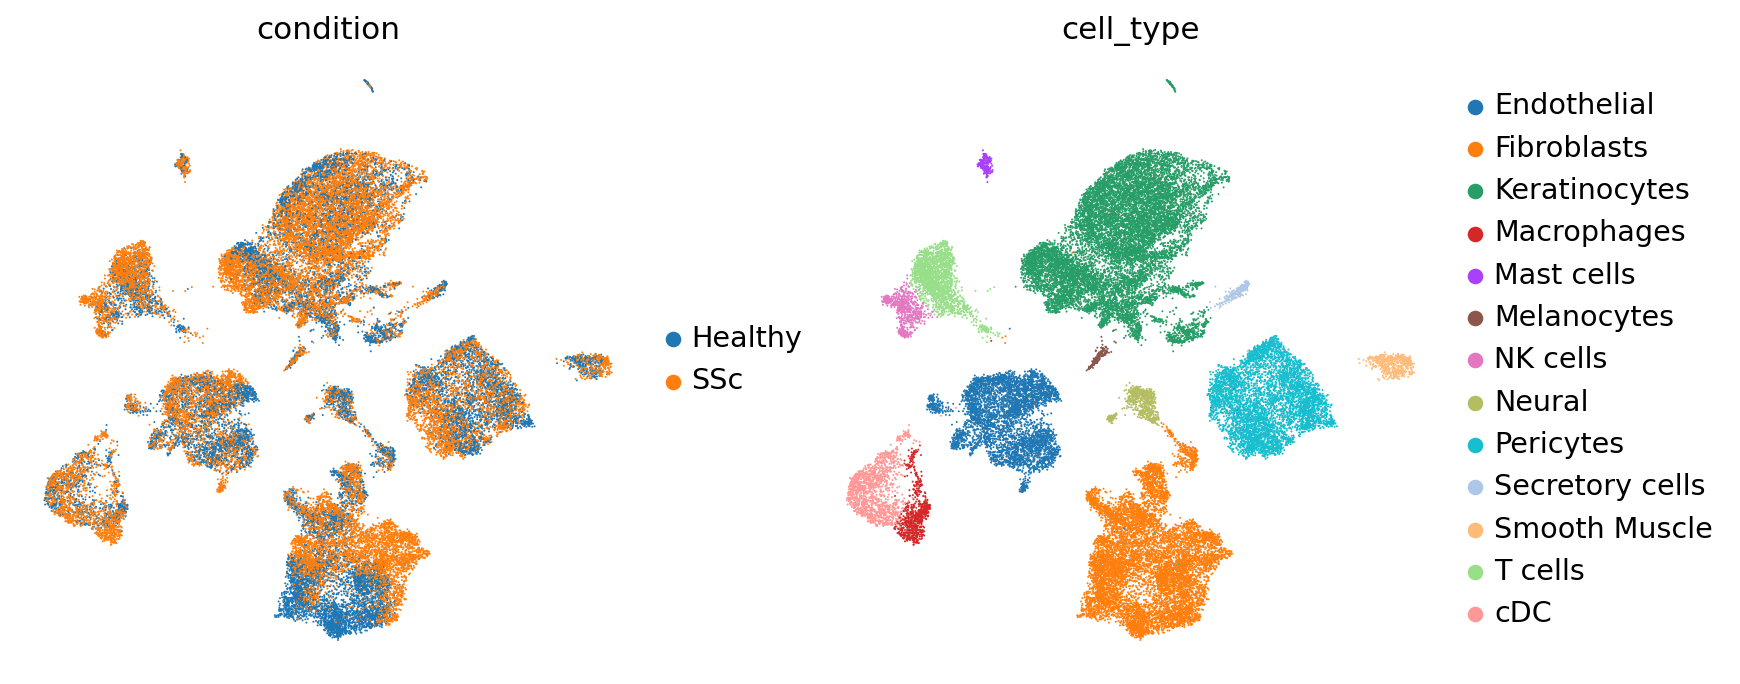

In [20]:
sc.pl.umap(adata2, color=['condition', 'cell_type'], frameon=False)

In [21]:
# how cell types are overlapped
c1 = adata1.obs['cell_type'].unique().tolist()
c2 = adata2.obs['cell_type'].unique().tolist()

In [22]:
set(c1).intersection(set(c2))

{'Endothelial',
 'Fibroblasts',
 'Keratinocytes',
 'Macrophages',
 'Mast cells',
 'Melanocytes',
 'NK cells',
 'Pericytes',
 'T cells',
 'cDC'}

In [23]:
adata1.obs['data'] = 'Gur2022'
adata2.obs['data'] = 'Tabib2021'

In [24]:
adata = ad.concat([adata1, adata2], keys=['Gur2022', 'Tabib2021'])

In [25]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [26]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

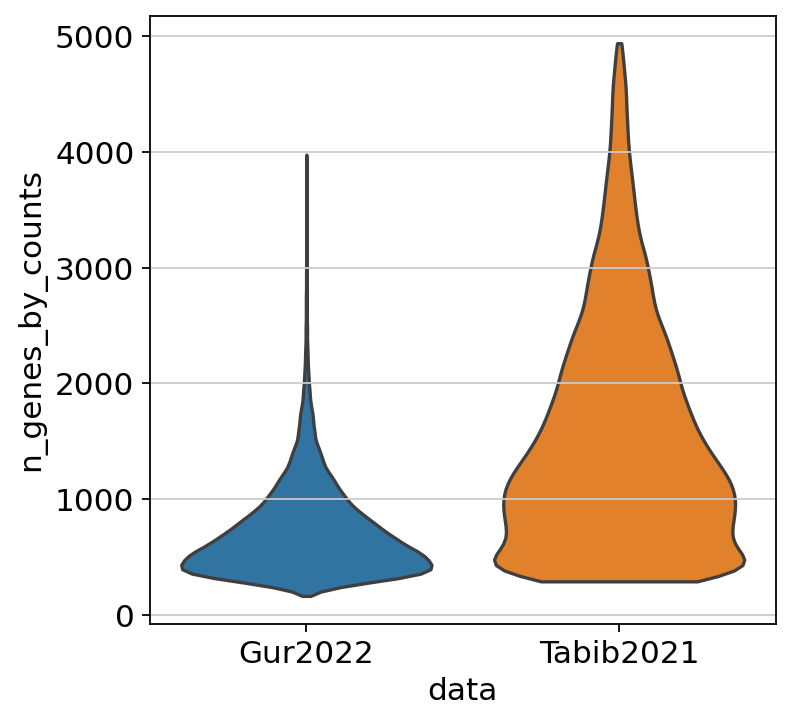

In [27]:
sc.pl.violin(adata, ['n_genes_by_counts'],
             jitter=0.4, multi_panel=True, groupby='data', size=0)

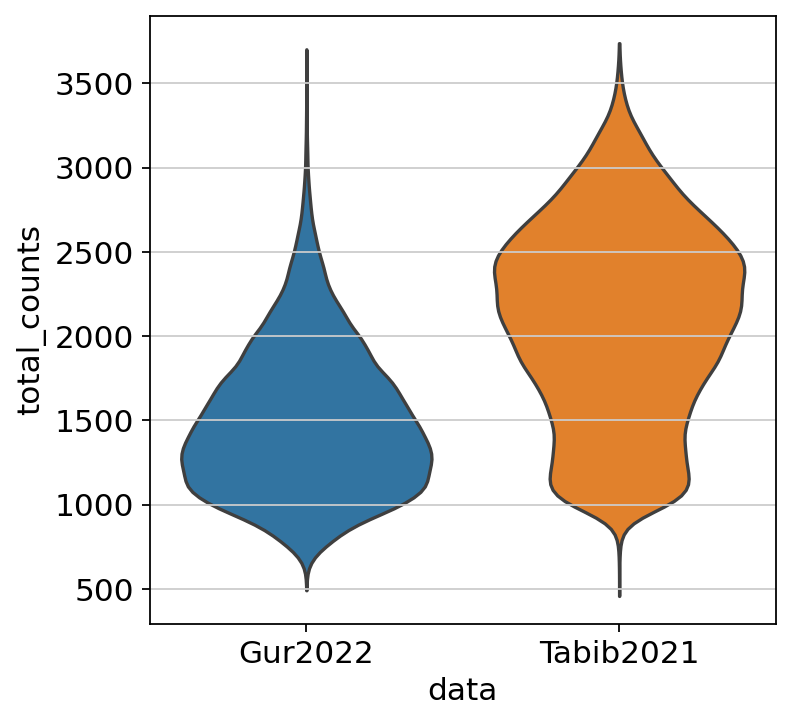

In [28]:
sc.pl.violin(adata, ['total_counts'],
             jitter=0.4, multi_panel=True, groupby='data', size=0)

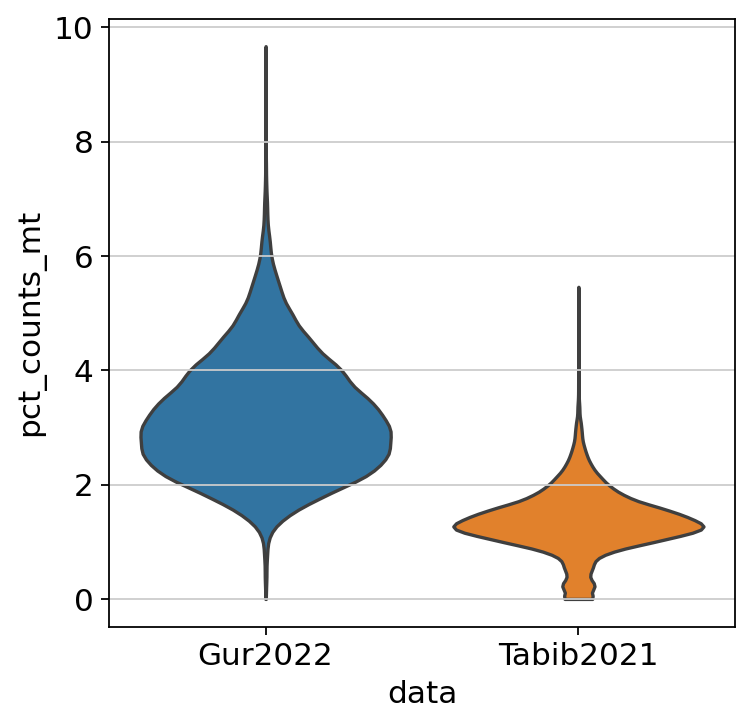

In [29]:
sc.pl.violin(adata, ['pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='data', size=0)

In [30]:
adata.X = adata.layers['counts'].copy()

In [31]:
adata

AnnData object with n_obs × n_vars = 95898 × 15275
    obs: 'patient_id', 'condition', 'cell_type', 'data', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'
    uns: 'data_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [32]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [33]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [34]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

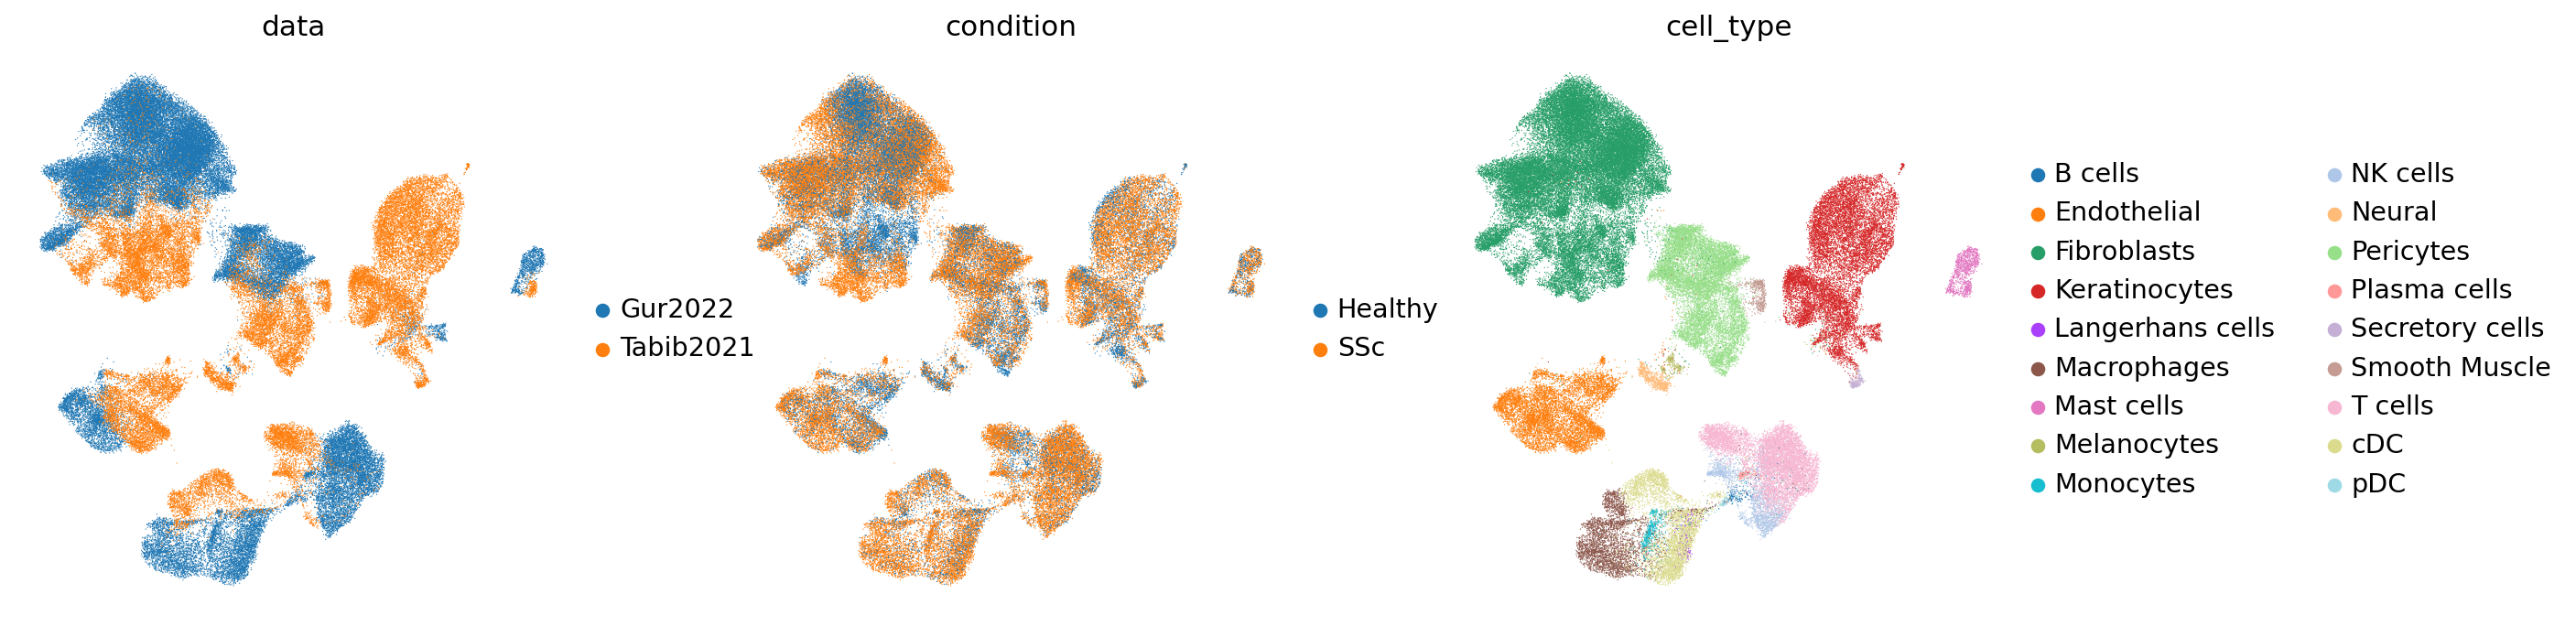

In [35]:
sc.pl.umap(adata, color=['data', 'condition', 'cell_type'], frameon=False)

In [36]:
# batch correction
from scipy.cluster.vq import kmeans2
import harmonypy as hm
import numpy as np

def cluster_fn(data, K):
    centroid, label = kmeans2(data, K, minit='++')
    return centroid

X = adata.obsm['X_pca'].astype(np.float64)

harmony_out = hm.run_harmony(X, adata.obs,
                             ['data'], cluster_fn=cluster_fn)

adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

2024-08-15 20:35:10,992 - harmonypy - INFO - Iteration 1 of 10
2024-08-15 20:36:08,604 - harmonypy - INFO - Iteration 2 of 10
2024-08-15 20:37:05,445 - harmonypy - INFO - Converged after 2 iterations


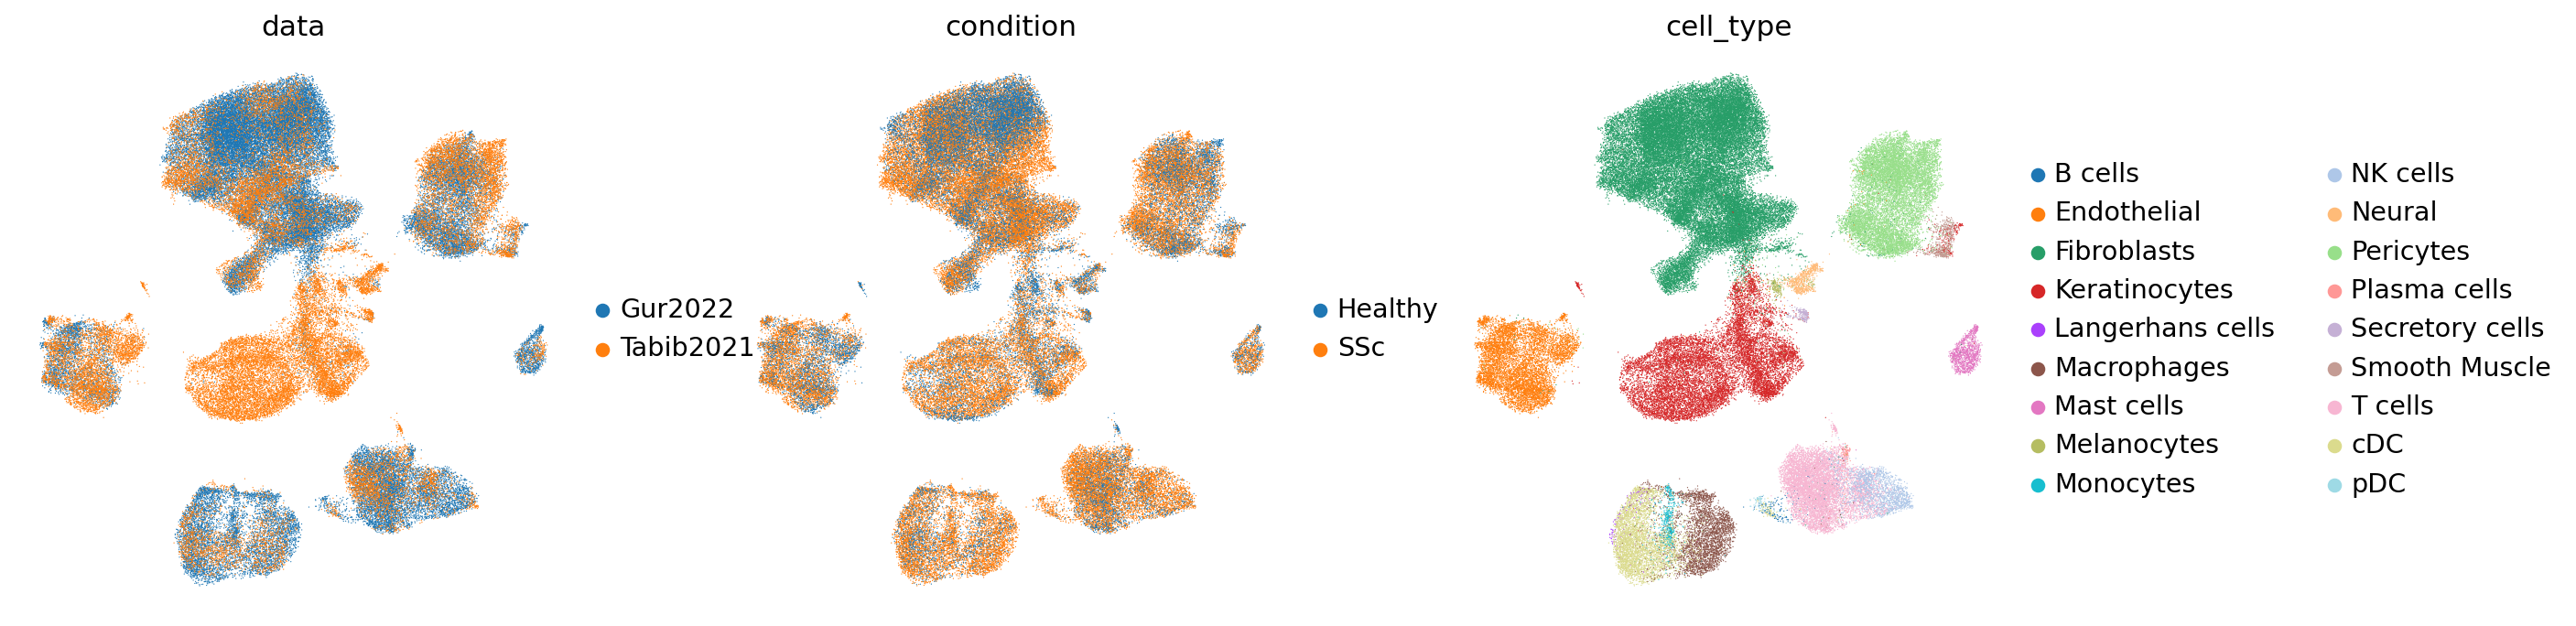

In [37]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['data', 'condition', 'cell_type'], frameon=False)

In [38]:
adata.write_h5ad('../../results/03_integrate_scrna/integrated.h5ad')